In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.insert(1, '../quantarhei')
sys.path.insert(2, '../spectre')
import quantarhei as qr
import spectre
import spectre.full as sef
import spectre.spectroscopy.abs_spectroscopy as abss

# (1.) Initial version - step 20

In [2]:
path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/H-scanopt-pyr06-1mode/results_H-pyr06-1mode-P-177_scanopt_01_2023-07-09_01-55-59"

In [17]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

ref_id = 6
ivalue = 970

lim0 = 0
lim1 = -3

C:\Users\micha\AppData\Local\Temp\ipykernel_47796\4220794966.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_47796\4220794966.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


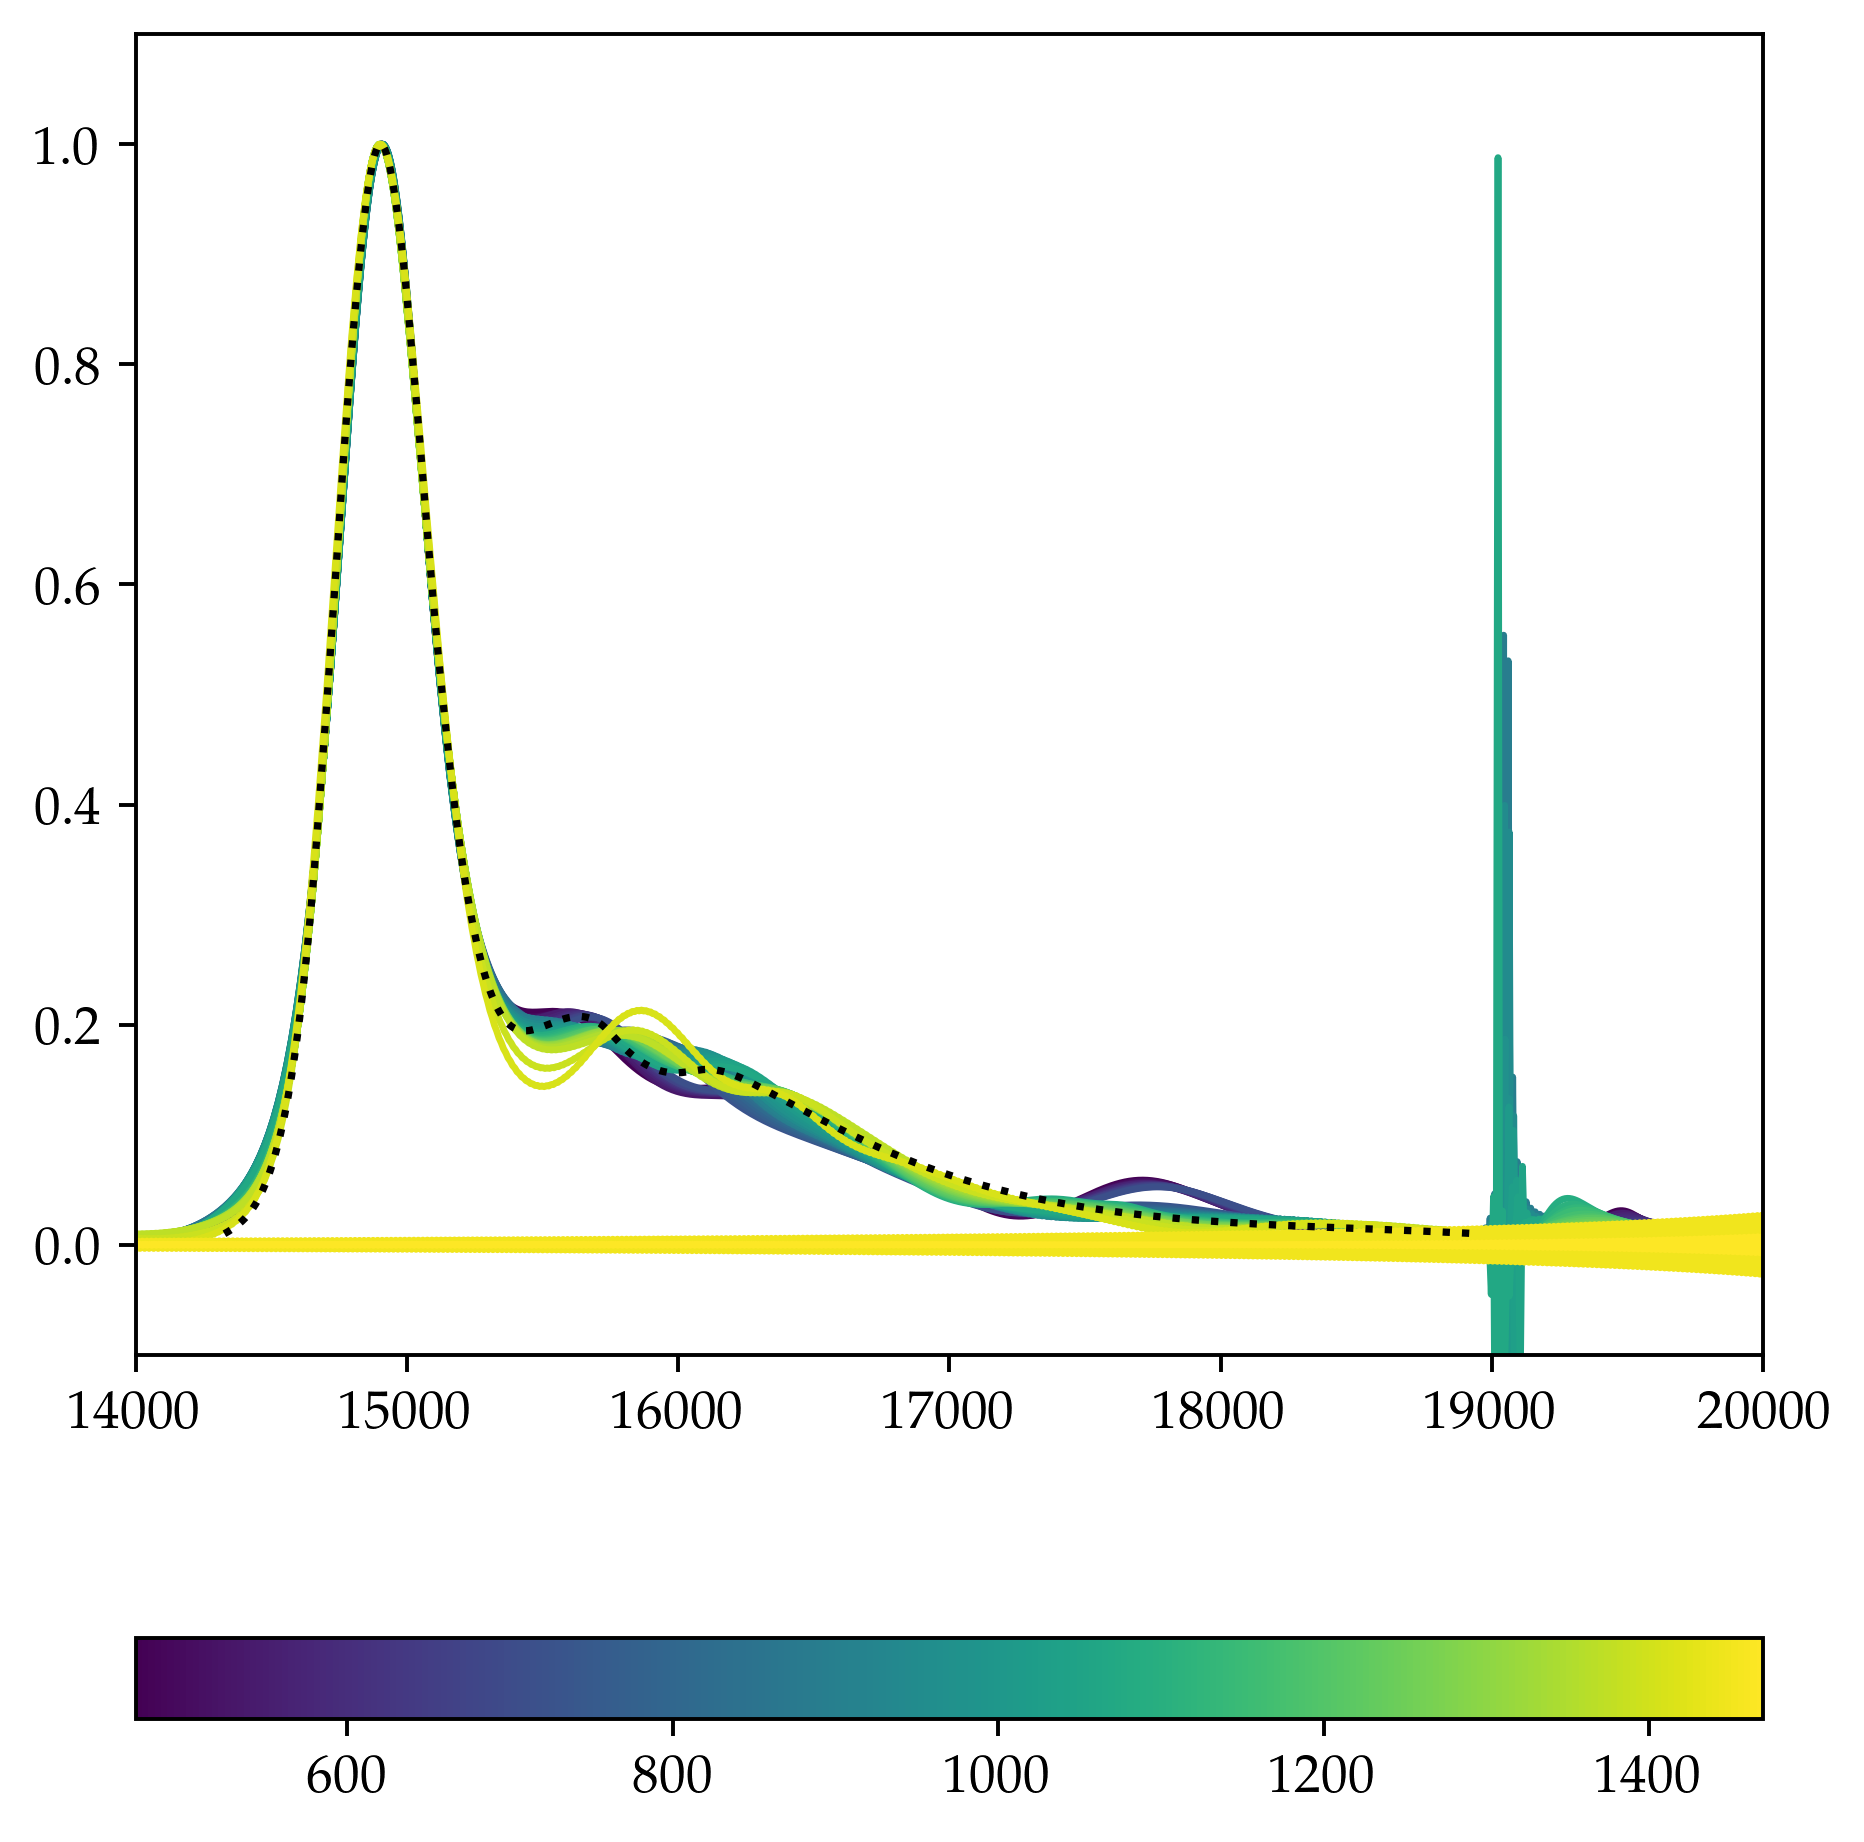

In [9]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(ref_id, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_47796\2928657806.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_47796\2928657806.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])


0.0563969877582


Text(0, 0.5, 'residuum')

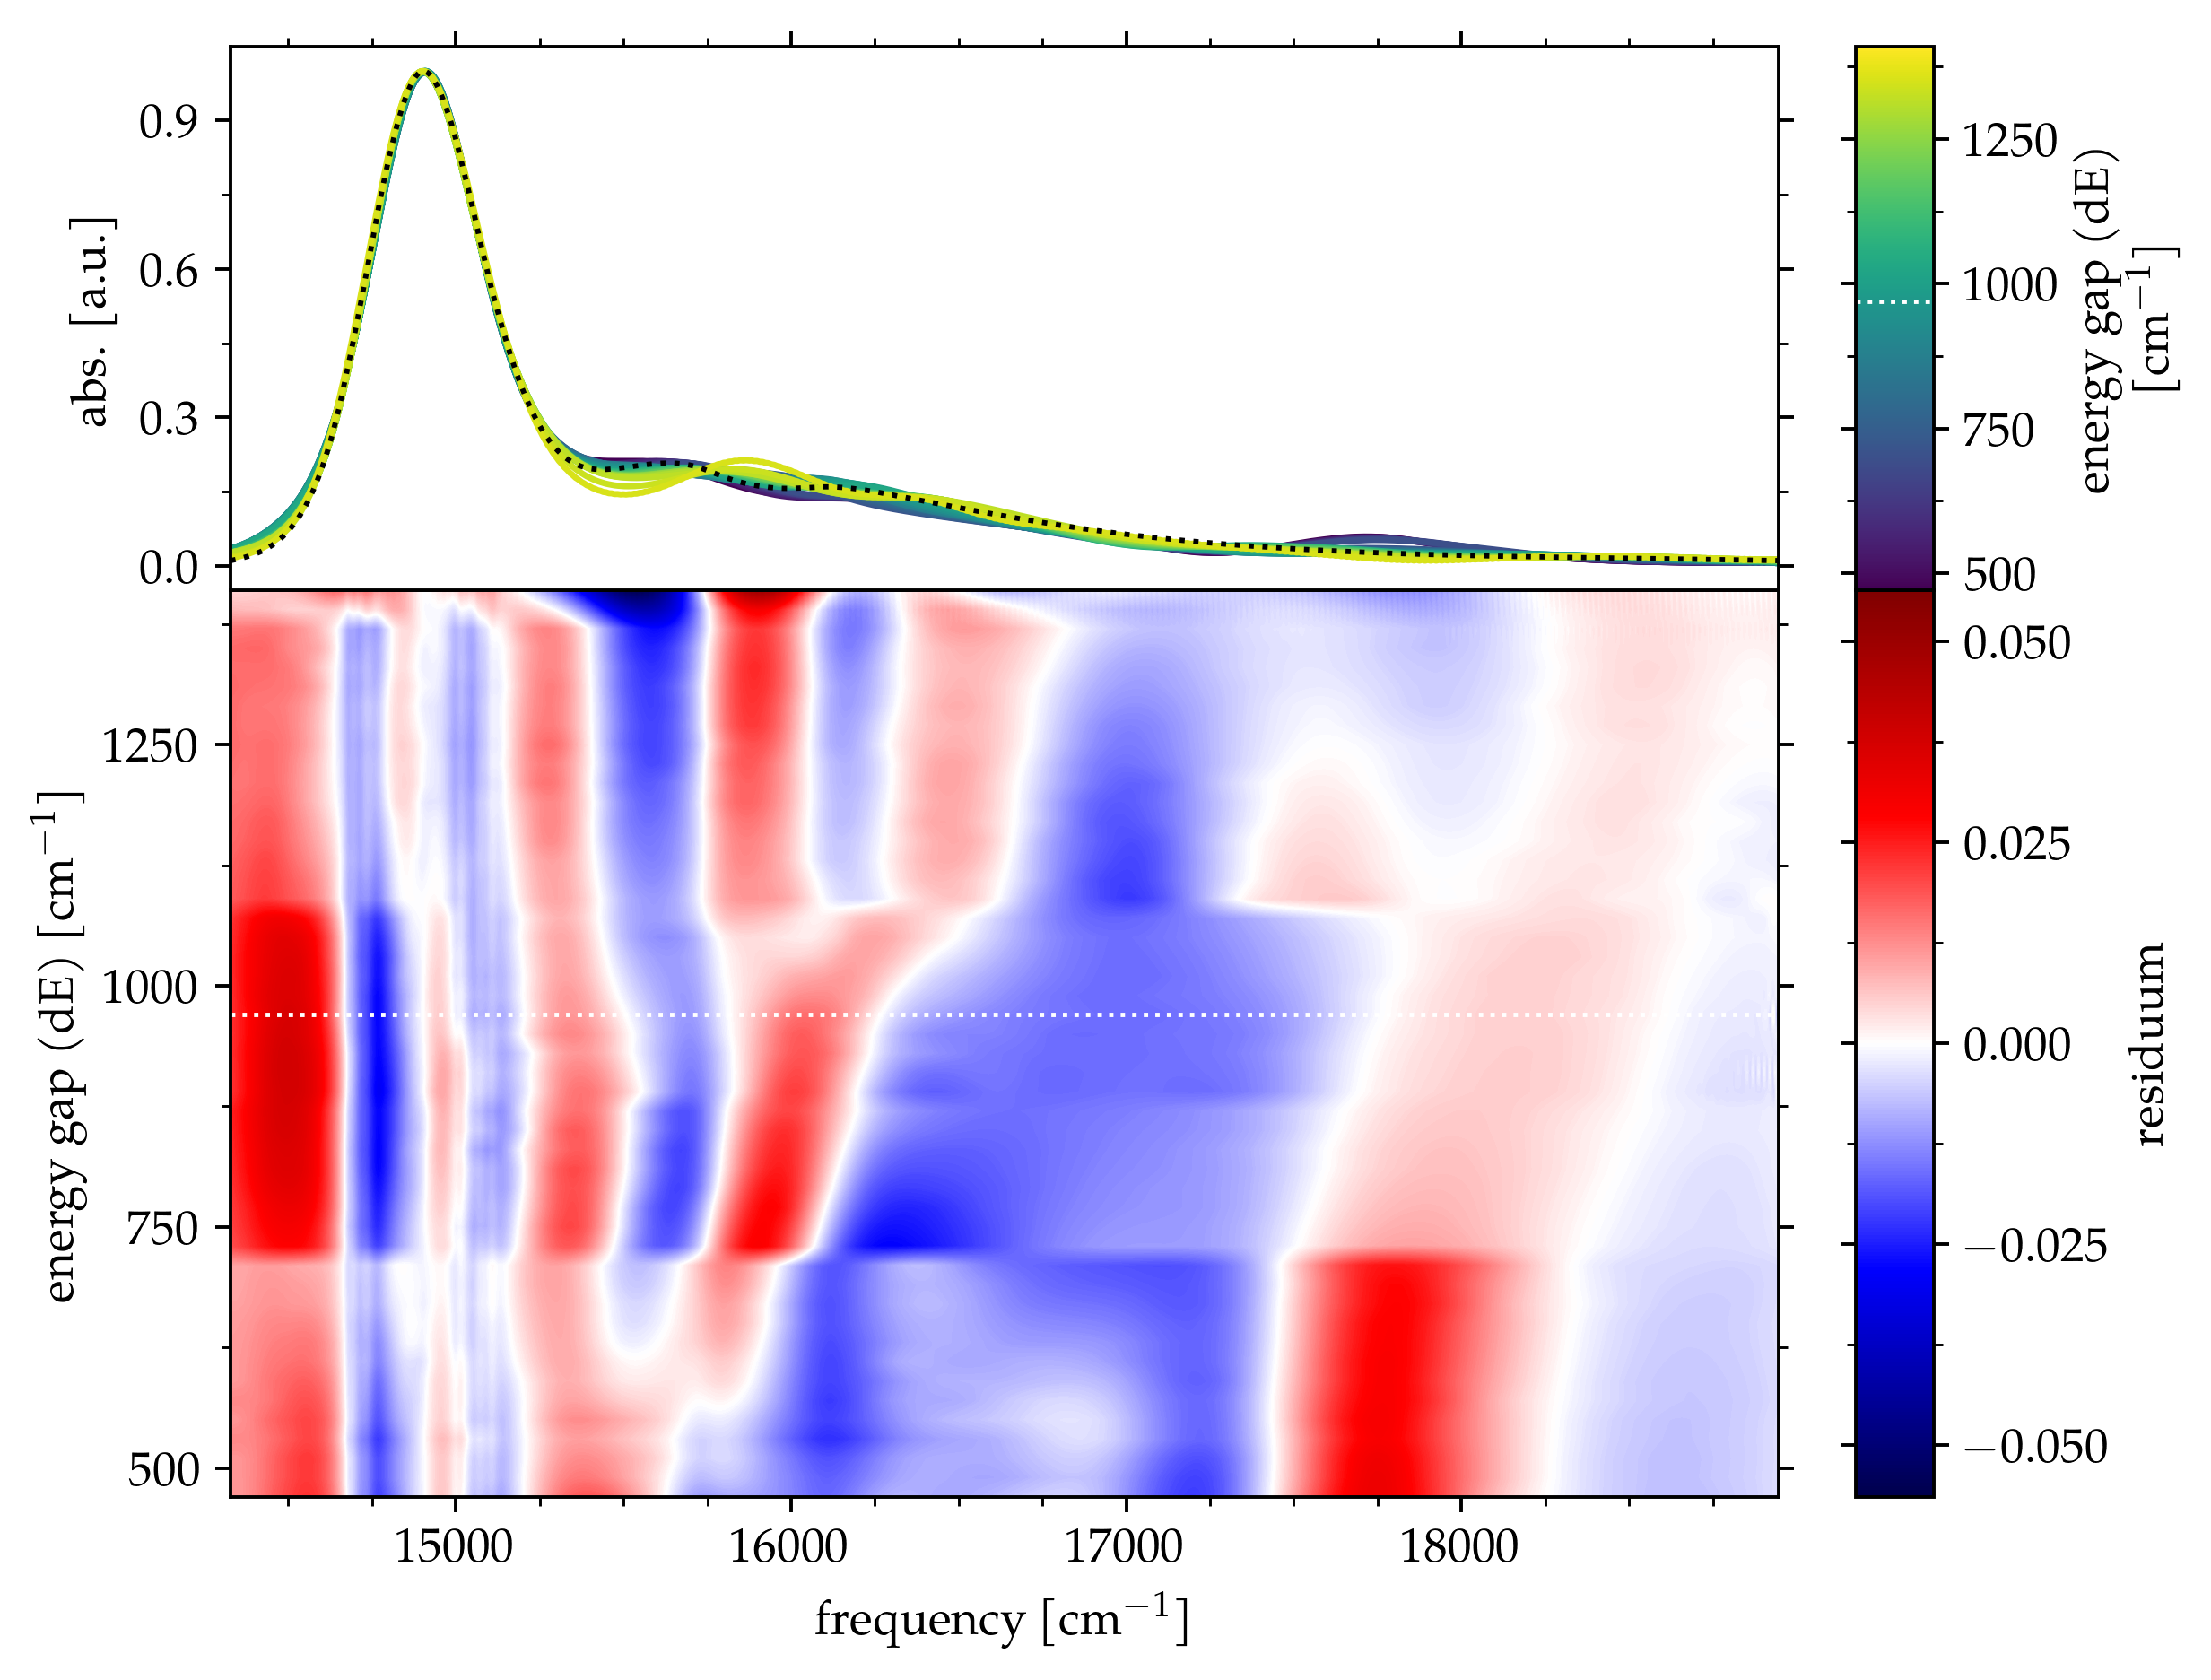

In [21]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(ref_id, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)[:,lim0:lim1]

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()
print(maximum)

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(ref_id, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax0.set_ylim(y[0,0], y[-1,0])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'energy gap (dE) [cm$^{-1}$]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering energy gap (dE) [cm$^{-1}$]')
ax4.set_ylabel(r'residuum')

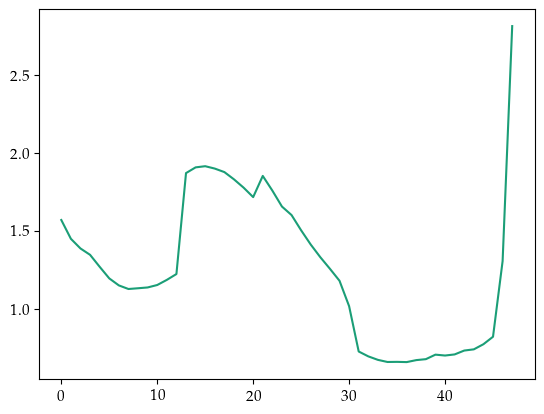

In [14]:
plt.plot((zax**2).sum(axis=1))

In [15]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_47796\2323635181.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'energy gap (dE) [cm$^{-1}$]')

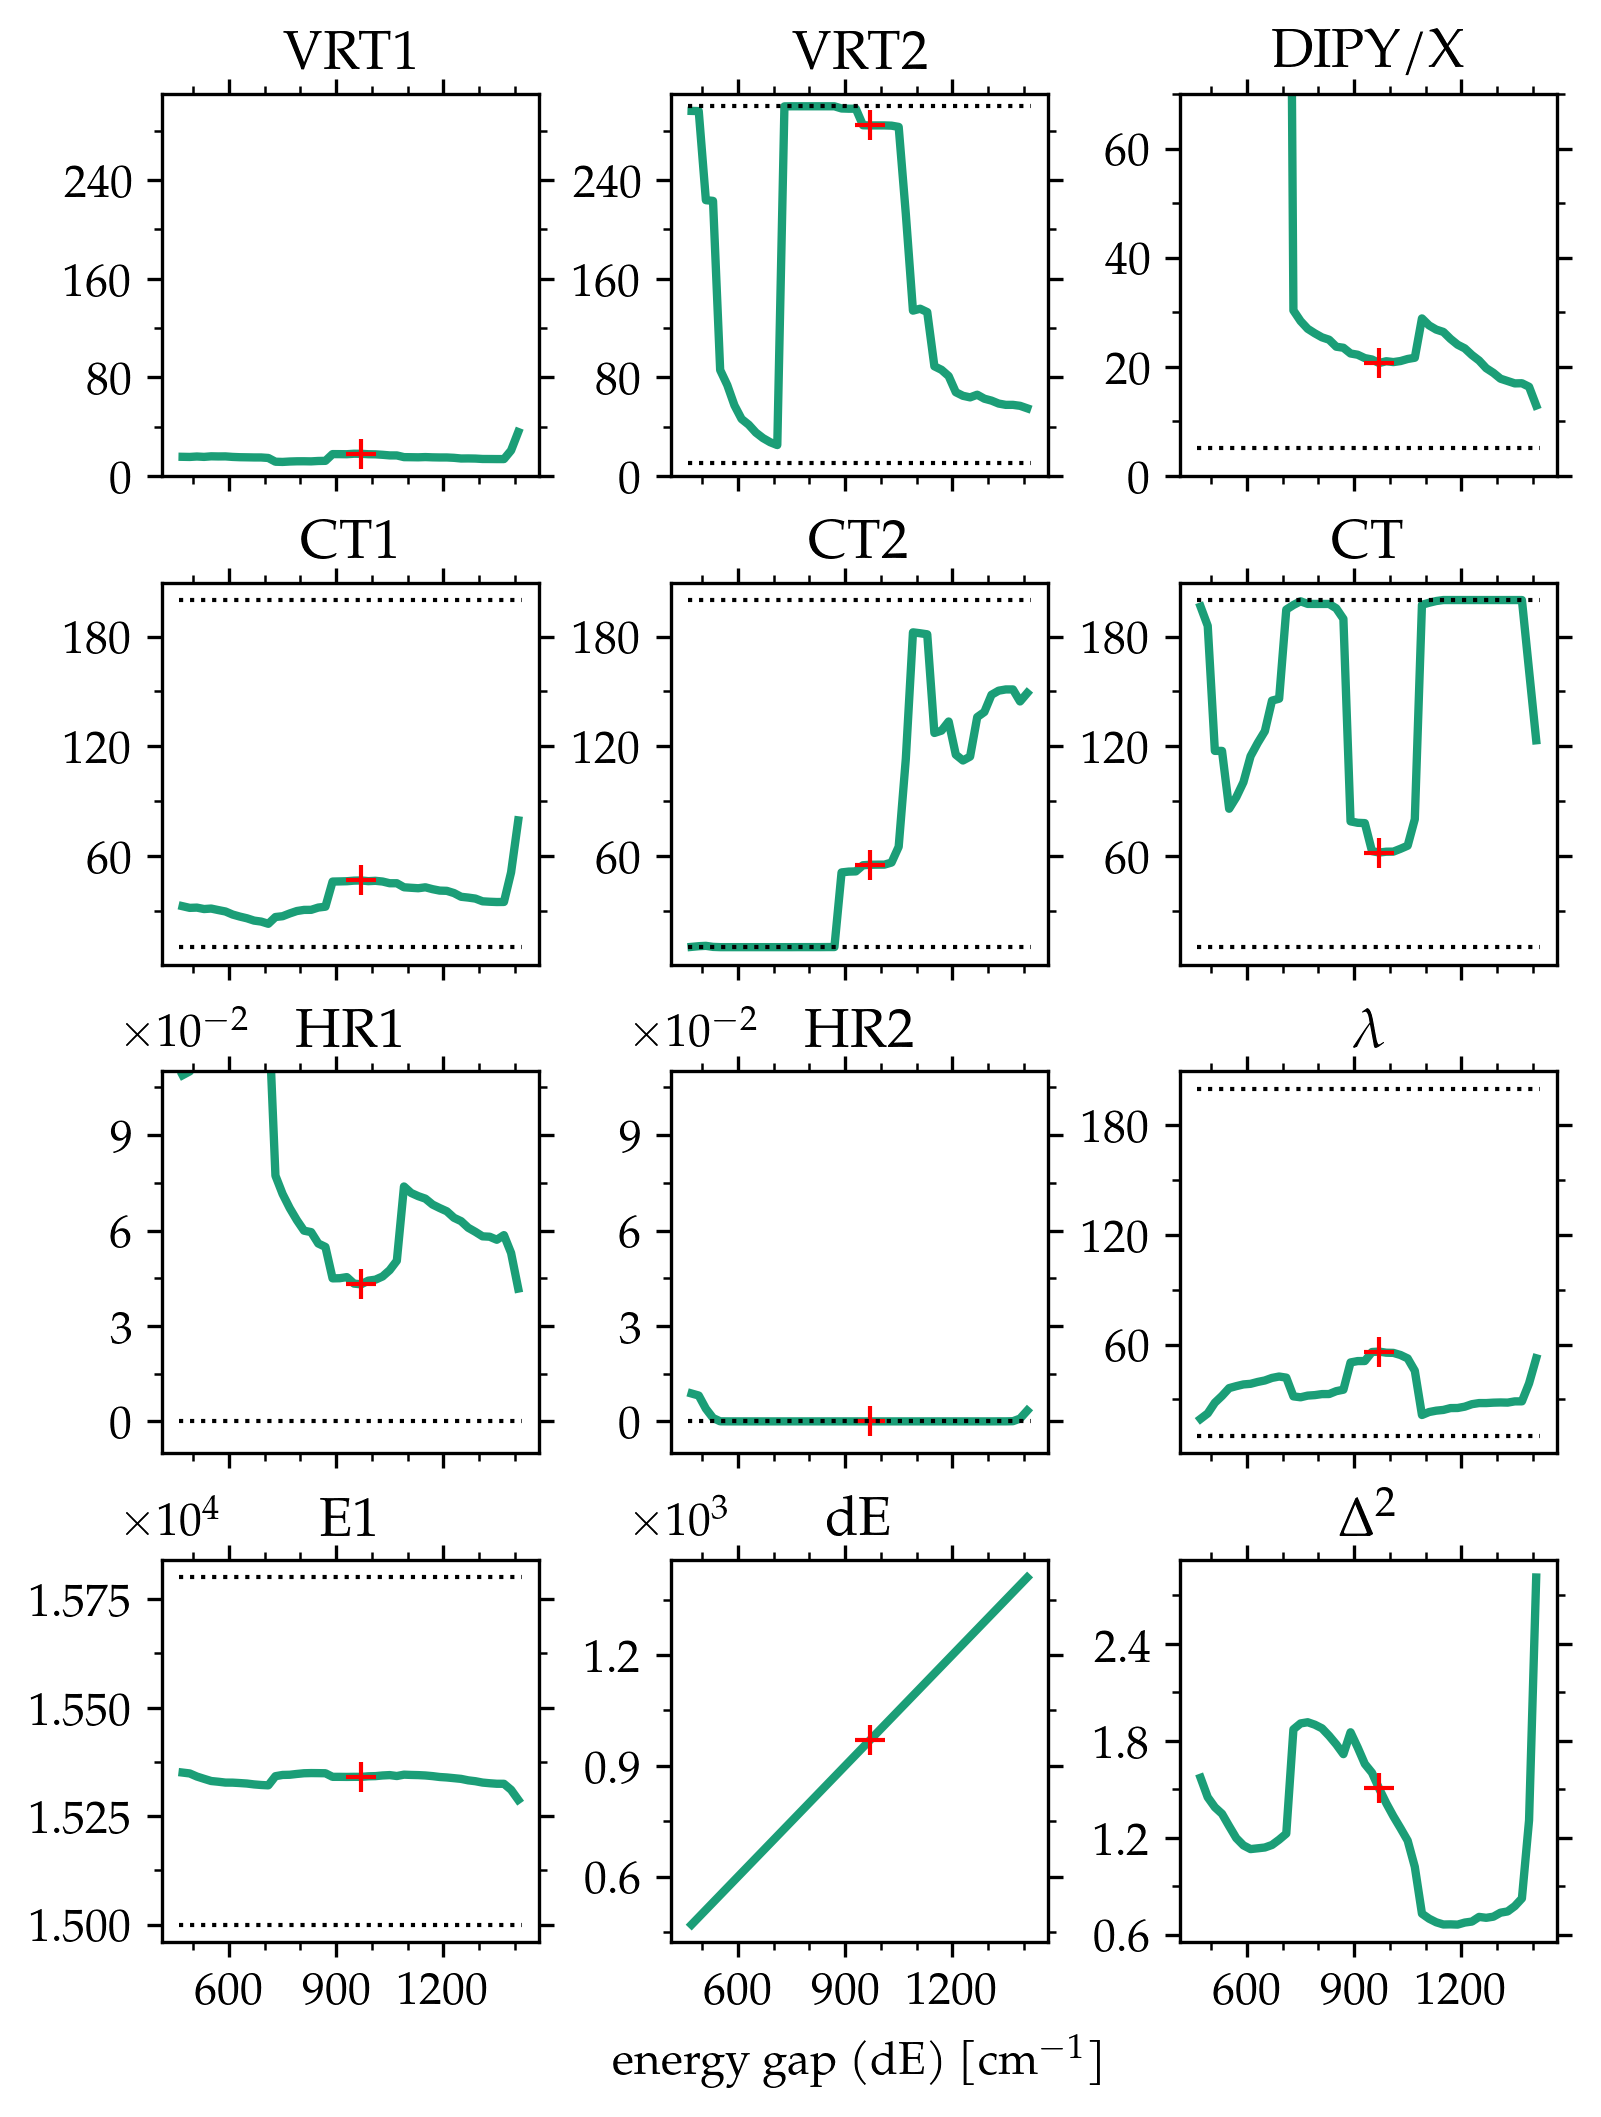

In [20]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[lim0:lim1]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == ivalue][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

# ## omega
# grid[3,1].plot(labels, om1, **pars)
# grid[3,1].plot(labels[ii], om1[ii], **mpars)
# grid[3,1].set_title('OM1')
# #draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

## dE
grid[3,1].plot(labels, de, **pars)
grid[3,1].plot(labels[ii], de[ii], **mpars)
grid[3,1].set_title('dE')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    

grid[0,0].set_ylim(0,310)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

#grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.11)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

#grid[0,0].set_xlim(10, 80)
grid[0,2].set_ylim(0,70)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(300))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(100))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('energy gap (dE) [cm$^{-1}$]')

# (2.) - Finer step - step 5

In [22]:
path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/H-scanopt-pyr06-1mode/results_H-pyr06-1mode-s5-P-177_scanopt_01_2023-07-10_10-17-11"

In [23]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

ref_id = 6
ivalue = 970

lim0 = 0
lim1 = None

C:\Users\micha\AppData\Local\Temp\ipykernel_47796\4220794966.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Reorg: 1575.54029494
Reorg: 28.1819379856
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.1s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 8.35s
Reorg: 1580.7512416
Reorg: 28.181935044
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.9s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.13s
Reorg: 1580.75121187
Reorg: 28.1819301435
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.49s
Reorg: 1579.61067862
Reorg: 28.1819301485
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.29s
Reorg: 1567.50076082
Reorg: 28.1819325667
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.38s
Reorg: 1547.75529897
Reorg: 28.1819262478
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.58s
Reorg: 1547.75533646
Reorg: 28.1819261657
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.45s
Reorg: 1538.00177698
Reorg: 28.3555363256
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.50s
Reorg: 1538.00168748
Reorg: 28.3555373805
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.76s
Reorg: 1527.87748343
Reorg: 28.542388579
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.84s
Reorg: 1525.1722849
Reorg: 28.7888581809
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.55s
Reorg: 1509.75767501
Reorg: 37.0319262284
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.75s
Reorg: 1509.94376878
Reorg: 44.2336939942
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.57s
Reorg: 1509.30855776
Reorg: 45.2713278082
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.76s
Reorg: 1501.97615227
Reorg: 64.4594098808
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.32s
Reorg: 1500.68263644
Reorg: 73.5089460544
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.20s
Spectrum calculation (CPU): 4.46s
Reorg: 1502.42903838
Reorg: 75.8246342698
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 5.06s
Reorg: 1492.08500304
Reorg: 79.9842097012
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.35s
Reorg: 1477.57068668
Reorg: 88.663243579
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.26s
Reorg: 1472.44776166
Reorg: 91.1281804437
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.74s
Reorg: 1459.81888787
Reorg: 105.506206483
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.0s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.22s
Reorg: 1442.19958545
Reorg: 113.246446251
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.64s
Reorg: 1436.70401921
Reorg: 114.366084206
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.35s
Reorg: 1431.79197908
Reorg: 115.5430879
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.43s
Reorg: 1418.7655239
Reorg: 134.752644022
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.0s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.22s
Reorg: 1412.88585281
Reorg: 143.686301937
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.65s
Reorg: 1409.20875464
Reorg: 149.902820326
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.41s
Reorg: 1399.20603252
Reorg: 178.913695357
System init: 5.11s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.20s
Spectrum calculation (CPU): 4.90s
Reorg: 1384.11940437
Reorg: 185.969337531
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.43s
Reorg: 1384.18428727
Reorg: 186.641201733
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.73s
Reorg: 1374.69206644
Reorg: 199.167723904
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.61s
Reorg: 1359.74931815
Reorg: 208.153362849
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.21s
Spectrum calculation (CPU): 4.53s
Reorg: 1354.69226953
Reorg: 202.918831106
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.40s
Reorg: 1343.03458078
Reorg: 216.066903314
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.09s
Spectrum calculation (CPU): 5.11s
Reorg: 1334.34695089
Reorg: 228.261261726
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.99s
Reorg: 1326.68130159
Reorg: 232.780925295
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.86s
Reorg: 1317.48193609
Reorg: 237.598075895
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.09s
Spectrum calculation (CPU): 5.04s
Reorg: 1305.05200588
Reorg: 253.220037545
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.09s
Spectrum calculation (CPU): 4.98s
Reorg: 1297.64446052
Reorg: 259.522245239
System init: 4.80s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.08s
Spectrum calculation (CPU): 4.89s
Reorg: 1288.27711776
Reorg: 266.426942305
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.08s
Spectrum calculation (CPU): 4.96s
Reorg: 1267.90440686
Reorg: 283.449779422
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.95s
Reorg: 1268.19063829
Reorg: 286.015804528
System init: 4.80s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 5.01s
Reorg: 1256.16673581
Reorg: 296.511469632
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.35s
Reorg: 1240.74501173
Reorg: 310.057089285
System init: 5.10s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.22s
Spectrum calculation (CPU): 4.76s
Reorg: 1238.40146745
Reorg: 310.296987049
System init: 6.28s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.28s
Spectrum calculation (CPU): 4.57s
Reorg: 1235.46497237
Reorg: 316.898994871
System init: 5.70s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.35s
Spectrum calculation (CPU): 5.16s
Reorg: 1220.81076689
Reorg: 322.411112173
System init: 5.49s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.36s
Spectrum calculation (CPU): 4.55s
Reorg: 1208.27415726
Reorg: 335.818363212
System init: 6.21s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.19s
Spectrum calculation (CPU): 4.84s
Reorg: 1199.7761083
Reorg: 336.042312904
System init: 6.20s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.38s
Spectrum calculation (CPU): 4.86s
Reorg: 1192.50988838
Reorg: 344.386122528
System init: 5.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 5.19s
Reorg: 1181.68427786
Reorg: 357.967164964
System init: 5.76s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.24s
Spectrum calculation (CPU): 4.71s
Reorg: 1174.17588826
Reorg: 362.301543031
System init: 6.18s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.19s
Spectrum calculation (CPU): 4.73s
Reorg: 1154.15327409
Reorg: 375.140359889
System init: 6.24s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.40s
Spectrum calculation (CPU): 4.95s
Reorg: 1145.17612431
Reorg: 384.176782165
System init: 5.81s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.4s finished


Tensor calculation: 1.39s
Spectrum calculation (CPU): 5.58s
Reorg: 1777.72699437
Reorg: 57.9504314752
System init: 6.30s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.39s
Spectrum calculation (CPU): 5.33s
Reorg: 1780.83359134
Reorg: 57.9504274904
System init: 6.40s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.27s
Spectrum calculation (CPU): 5.14s
Reorg: 1827.16465038
Reorg: 30.1435460993
System init: 5.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.54s
Spectrum calculation (CPU): 5.03s
Reorg: 1837.04930083
Reorg: 30.3353293792
System init: 5.77s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.23s
Spectrum calculation (CPU): 5.28s
Reorg: 1845.76163559
Reorg: 28.3382737698
System init: 5.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.21s
Spectrum calculation (CPU): 4.53s
Reorg: 1847.20672206
Reorg: 28.3382738697
System init: 6.49s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.27s
Spectrum calculation (CPU): 4.69s
Reorg: 1873.98242623
Reorg: 28.4888954173
System init: 5.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.51s
Spectrum calculation (CPU): 4.97s
Reorg: 1878.76847482
Reorg: 28.4890683095
System init: 5.70s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.3s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 5.55s
Reorg: 1883.69510617
Reorg: 28.4894778757
System init: 5.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 5.18s
Reorg: 1887.2673887
Reorg: 28.4895943481
System init: 6.62s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.3s finished


Tensor calculation: 1.31s
Spectrum calculation (CPU): 5.47s
Reorg: 1919.62663573
Reorg: 29.0375112593
System init: 6.43s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.33s
Spectrum calculation (CPU): 5.19s
Reorg: 1922.55610045
Reorg: 29.0375132799
System init: 6.17s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.33s
Spectrum calculation (CPU): 5.26s
Reorg: 1926.14779318
Reorg: 29.0377333525
System init: 5.70s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.35s
Spectrum calculation (CPU): 4.73s
Reorg: 1928.1580941
Reorg: 29.0515054585
System init: 6.63s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.76s
Reorg: 1957.45395026
Reorg: 29.0611570911
System init: 6.51s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.51s
Spectrum calculation (CPU): 5.14s
Reorg: 1966.65264844
Reorg: 51.4717557997
System init: 6.29s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.44s
Spectrum calculation (CPU): 5.03s
Reorg: 1981.40712673
Reorg: 52.4496812677
System init: 5.43s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.30s
Spectrum calculation (CPU): 4.63s
Reorg: 1986.15267403
Reorg: 52.7678951235
System init: 6.18s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.27s
Spectrum calculation (CPU): 4.62s
Reorg: 1990.1406879
Reorg: 52.7714422069
System init: 5.80s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.95s
Spectrum calculation (CPU): 4.96s
Reorg: 2036.64933611
Reorg: 247.055922342
System init: 5.63s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 4.93s
Reorg: 2052.37137196
Reorg: 250.28503815
System init: 5.56s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.20s
Spectrum calculation (CPU): 4.79s
Reorg: 2052.52443622
Reorg: 250.286867745
System init: 6.18s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.23s
Spectrum calculation (CPU): 4.64s
Reorg: 2054.63828553
Reorg: 254.108295025
System init: 5.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.96s
Spectrum calculation (CPU): 4.96s
Reorg: 2060.46034777
Reorg: 258.546021079
System init: 5.38s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.24s
Spectrum calculation (CPU): 4.85s
Reorg: 2065.93643182
Reorg: 258.619275366
System init: 5.47s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 4.59s
Reorg: 2076.0027723
Reorg: 260.254732862
System init: 6.64s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.29s
Spectrum calculation (CPU): 4.86s
Reorg: 2078.51535972
Reorg: 260.302585443
System init: 6.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.54s
Spectrum calculation (CPU): 4.70s
Reorg: 2072.20315974
Reorg: 257.989390484
System init: 5.69s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.32s
Spectrum calculation (CPU): 5.26s
Reorg: 2077.92587346
Reorg: 257.843662157
System init: 5.50s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.28s
Spectrum calculation (CPU): 4.90s
Reorg: 2081.90955646
Reorg: 257.808064437
System init: 6.27s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.29s
Spectrum calculation (CPU): 4.66s
Reorg: 2086.30903315
Reorg: 257.826676334
System init: 6.28s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.48s
Spectrum calculation (CPU): 5.12s
Reorg: 2086.52936958
Reorg: 257.648137409
System init: 5.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.29s
Spectrum calculation (CPU): 5.01s
Reorg: 2095.51267549
Reorg: 251.420591736
System init: 5.74s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.30s
Spectrum calculation (CPU): 4.78s
Reorg: 2100.79995418
Reorg: 251.510664384
System init: 6.31s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.25s
Spectrum calculation (CPU): 4.62s
Reorg: 2096.37840241
Reorg: 250.481059503
System init: 6.24s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.58s
Spectrum calculation (CPU): 4.98s
Reorg: 2051.33106661
Reorg: 214.292767591
System init: 5.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.26s
Spectrum calculation (CPU): 4.95s
Reorg: 2034.19366173
Reorg: 167.312463384
System init: 5.80s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.30s
Spectrum calculation (CPU): 4.61s
Reorg: 2034.19114775
Reorg: 167.312457788
System init: 6.22s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.24s
Spectrum calculation (CPU): 5.01s
Reorg: 2049.33524575
Reorg: 167.479347529
System init: 6.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.44s
Spectrum calculation (CPU): 4.87s
Reorg: 2050.1285507
Reorg: 167.767039604
System init: 5.49s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.18s
Spectrum calculation (CPU): 5.30s
Reorg: 2017.92777802
Reorg: 169.602994811
System init: 5.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.42s
Spectrum calculation (CPU): 4.98s
Reorg: 2019.56010925
Reorg: 169.613425021
System init: 6.16s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.21s
Spectrum calculation (CPU): 5.05s
Reorg: 2020.35590183
Reorg: 169.613541343
System init: 6.35s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.28s
Spectrum calculation (CPU): 4.99s
Reorg: 2023.16886519
Reorg: 169.614153833
System init: 5.59s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.49s
Spectrum calculation (CPU): 5.34s
Reorg: 2027.00146944
Reorg: 169.961363198
System init: 5.57s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.22s
Spectrum calculation (CPU): 4.84s
Reorg: 2019.85808528
Reorg: 167.353588444
System init: 6.11s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.9s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 4.16s
Reorg: 1969.76934982
Reorg: 146.07588972
System init: 6.39s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.26s
Spectrum calculation (CPU): 4.78s
Reorg: 1973.39547541
Reorg: 146.051035185
System init: 5.44s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.39s
Spectrum calculation (CPU): 5.33s
Reorg: 1978.48104329
Reorg: 146.046484721
System init: 5.62s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.21s
Spectrum calculation (CPU): 4.49s
Reorg: 1984.61392535
Reorg: 146.047801893
System init: 5.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.25s
Spectrum calculation (CPU): 4.66s
Reorg: 1988.45820575
Reorg: 146.050899373
System init: 6.45s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.23s
Spectrum calculation (CPU): 4.80s
Reorg: 1991.61514622
Reorg: 146.052612026
System init: 5.60s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 5.25s
Reorg: 2008.24742909
Reorg: 146.160666861
System init: 5.46s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.32s
Spectrum calculation (CPU): 4.70s
Reorg: 2010.03643748
Reorg: 146.195308351
System init: 5.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.32s
Spectrum calculation (CPU): 4.62s
Reorg: 2011.21350716
Reorg: 146.215576797
System init: 6.41s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.26s
Spectrum calculation (CPU): 4.65s
Reorg: 2011.74021383
Reorg: 146.216675604
System init: 5.76s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.46s
Spectrum calculation (CPU): 5.26s
Reorg: 2011.76701257
Reorg: 146.21671836
System init: 6.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 4.82s
Reorg: 2018.58959674
Reorg: 146.237575856
System init: 6.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.38s
Spectrum calculation (CPU): 4.92s
Reorg: 2042.49120221
Reorg: 176.98602697
System init: 6.45s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.68s
Spectrum calculation (CPU): 5.10s
Reorg: 2042.53628126
Reorg: 176.9862931
System init: 5.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 5.26s
Reorg: 2067.14193022
Reorg: 449.616699987
System init: 6.12s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.49s
Spectrum calculation (CPU): 4.70s
Reorg: 2067.14193022
Reorg: 449.616699987
System init: 6.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.40s
Spectrum calculation (CPU): 4.75s
Reorg: 2080.69288197
Reorg: 449.816570813
System init: 6.54s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.97s
Spectrum calculation (CPU): 5.08s
Reorg: 2170.43438891
Reorg: 808.677289876
System init: 6.15s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.4s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 5.56s
Reorg: 2175.66617485
Reorg: 808.695826212
System init: 6.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.40s
Spectrum calculation (CPU): 4.90s
Reorg: 2158.87376128
Reorg: 937.922603295
System init: 6.48s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.36s
Spectrum calculation (CPU): 4.72s
Reorg: 2152.65513627
Reorg: 966.575214729
System init: 6.19s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 2.13s
Spectrum calculation (CPU): 4.98s
Reorg: 2159.40490842
Reorg: 989.776373492
System init: 5.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.31s
Spectrum calculation (CPU): 5.29s
Reorg: 2165.59361972
Reorg: 986.240295138
System init: 5.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.44s
Spectrum calculation (CPU): 4.91s
Reorg: 2154.26306255
Reorg: 1001.1072131
System init: 6.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.35s
Spectrum calculation (CPU): 4.93s
Reorg: 2153.84174198
Reorg: 1002.27895365
System init: 6.43s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.90s
Spectrum calculation (CPU): 5.36s
Reorg: 2155.11932091
Reorg: 1002.89439833
System init: 5.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.41s
Spectrum calculation (CPU): 5.29s
Reorg: 2154.61489374
Reorg: 1004.6256329
System init: 5.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 4.91s
Reorg: 2140.02090437
Reorg: 1011.35772439
System init: 6.69s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.32s
Spectrum calculation (CPU): 4.88s
Reorg: 2142.33128693
Reorg: 1011.44229297
System init: 6.25s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 2.08s
Spectrum calculation (CPU): 5.19s
Reorg: 2140.38933185
Reorg: 985.708584952
System init: 5.76s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.46s
Spectrum calculation (CPU): 5.33s
Reorg: 2129.00608873
Reorg: 995.159564384
System init: 6.29s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.43s
Spectrum calculation (CPU): 4.94s
Reorg: 2126.28011027
Reorg: 1007.54458118
System init: 6.79s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.30s
Spectrum calculation (CPU): 5.10s
Reorg: 2139.59099653
Reorg: 1052.58451686
System init: 6.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.3s finished


Tensor calculation: 1.91s
Spectrum calculation (CPU): 5.53s
Reorg: 2142.01264289
Reorg: 1056.21601433
System init: 5.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.2s finished


Tensor calculation: 1.33s
Spectrum calculation (CPU): 5.41s
Reorg: 2143.62833924
Reorg: 1056.25737321
System init: 5.74s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.42s
Spectrum calculation (CPU): 4.61s
Reorg: 2121.0223869
Reorg: 1069.96693854
System init: 6.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.38s
Spectrum calculation (CPU): 5.10s
Reorg: 2138.64699284
Reorg: 1088.92755645
System init: 6.33s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.4s finished


Tensor calculation: 1.75s
Spectrum calculation (CPU): 5.59s
Reorg: 2140.34358817
Reorg: 1103.05954575
System init: 5.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.43s
Spectrum calculation (CPU): 5.37s
Reorg: 2133.49549491
Reorg: 1108.18500286
System init: 6.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.35s
Spectrum calculation (CPU): 4.93s
Reorg: 2132.61970181
Reorg: 1111.29123787
System init: 6.77s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 5.19s
Reorg: 2134.09283589
Reorg: 1116.13463182
System init: 6.12s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.6s finished


Tensor calculation: 1.68s
Spectrum calculation (CPU): 5.80s
Reorg: 2131.97372685
Reorg: 1135.12910255
System init: 6.42s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.49s
Spectrum calculation (CPU): 5.24s
Reorg: 2138.82535604
Reorg: 1127.29922506
System init: 6.43s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.55s
Spectrum calculation (CPU): 4.96s
Reorg: 2126.98067614
Reorg: 1162.79570909
System init: 6.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.38s
Spectrum calculation (CPU): 4.97s
Reorg: 2111.76969162
Reorg: 1202.72265848
System init: 6.48s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.2s finished


Tensor calculation: 1.58s
Spectrum calculation (CPU): 5.40s
Reorg: 2110.48155766
Reorg: 1206.62590834
System init: 5.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 4.74s
Reorg: 2107.81642176
Reorg: 1217.0710491
System init: 6.59s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.35s
Spectrum calculation (CPU): 4.84s
Reorg: 2103.72359543
Reorg: 1241.76124832
System init: 6.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 4.80s
Reorg: 2087.51489237
Reorg: 1307.1034982
System init: 6.08s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.2s finished


Tensor calculation: 1.53s
Spectrum calculation (CPU): 5.65s
Reorg: 2084.93941937
Reorg: 1274.66141741
System init: 6.22s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.2s finished


Tensor calculation: 1.56s
Spectrum calculation (CPU): 5.44s
Reorg: 2073.72261857
Reorg: 1275.95199406
System init: 6.25s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.40s
Spectrum calculation (CPU): 5.06s
Reorg: 2070.48148705
Reorg: 1290.29551864
System init: 6.65s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 4.95s
Reorg: 2060.31757162
Reorg: 1298.77843295
System init: 6.14s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.3s finished


Tensor calculation: 1.54s
Spectrum calculation (CPU): 5.54s
Reorg: 2048.36129006
Reorg: 1311.65133649
System init: 5.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 5.24s
Reorg: 2039.21975648
Reorg: 1331.13328864
System init: 6.26s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 5.13s
Reorg: 2031.17350914
Reorg: 1434.79897089
System init: 6.48s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.45s
Spectrum calculation (CPU): 4.91s
Reorg: 2029.83777229
Reorg: 1440.30662662
System init: 5.75s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.46s
Spectrum calculation (CPU): 5.22s
Reorg: 2022.25880369
Reorg: 1467.25766445
System init: 6.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.39s
Spectrum calculation (CPU): 4.97s
Reorg: 2006.78422074
Reorg: 1490.04743705
System init: 6.74s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.32s
Spectrum calculation (CPU): 5.10s
Reorg: 2003.18788121
Reorg: 1522.25402687
System init: 6.32s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.68s
Spectrum calculation (CPU): 5.16s
Reorg: 1999.84954988
Reorg: 1552.47624221
System init: 5.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.4s finished


Tensor calculation: 1.35s
Spectrum calculation (CPU): 5.60s
Reorg: 2006.34569476
Reorg: 1608.54682387
System init: 5.73s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.40s
Spectrum calculation (CPU): 4.96s
Reorg: 1995.99069898
Reorg: 1645.50371071
System init: 6.62s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.28s
Spectrum calculation (CPU): 5.00s
Reorg: 1984.86393539
Reorg: 1681.00308118
System init: 6.13s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.88s
Spectrum calculation (CPU): 5.10s
Reorg: 1969.36560054
Reorg: 1708.13026081
System init: 5.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.2s finished


Tensor calculation: 1.38s
Spectrum calculation (CPU): 5.44s
Reorg: 1968.36848294
Reorg: 1738.49481855
System init: 5.67s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.38s
Spectrum calculation (CPU): 5.08s
Reorg: 1966.8319233
Reorg: 1768.23804346
System init: 6.62s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.36s
Spectrum calculation (CPU): 4.86s
Reorg: 1962.85502929
Reorg: 1816.38237667
System init: 6.19s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.90s
Spectrum calculation (CPU): 5.25s
Reorg: 1949.92503869
Reorg: 1834.27968636
System init: 6.18s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.43s
Spectrum calculation (CPU): 5.32s
Reorg: 1940.32988428
Reorg: 1864.69044821
System init: 5.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.33s
Spectrum calculation (CPU): 4.89s
Reorg: 1934.48678951
Reorg: 1875.70294484
System init: 6.50s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.43s
Spectrum calculation (CPU): 5.01s
Reorg: 1934.4758518
Reorg: 1899.53989652
System init: 6.14s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.4s finished


Tensor calculation: 1.88s
Spectrum calculation (CPU): 5.56s
Reorg: 1932.04270874
Reorg: 1930.09655436
System init: 6.21s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.3s finished


Tensor calculation: 1.34s
Spectrum calculation (CPU): 5.51s
Reorg: 1937.61829779
Reorg: 2063.60100465
System init: 6.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.33s
Spectrum calculation (CPU): 5.14s
Reorg: 1937.63540405
Reorg: 2063.60139272
System init: 6.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.22s
Spectrum calculation (CPU): 5.20s
Reorg: 1928.85386063
Reorg: 2086.85621157
System init: 5.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.4s finished


Tensor calculation: 1.55s
Spectrum calculation (CPU): 5.63s
Reorg: 1936.81162888
Reorg: 2173.44668749
System init: 6.14s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.44s
Spectrum calculation (CPU): 5.26s
Reorg: 1935.90500495
Reorg: 2221.90230554
System init: 6.33s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.43s
Spectrum calculation (CPU): 4.88s
Reorg: 1936.22479436
Reorg: 2226.12050488
System init: 7.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.32s
Spectrum calculation (CPU): 4.95s
Reorg: 1930.12431235
Reorg: 2236.54639017
System init: 6.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.2s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 5.44s
Reorg: 1924.17877295
Reorg: 2347.57360202
System init: 5.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 4.74s
Reorg: 1933.76410273
Reorg: 2397.80495047
System init: 6.71s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.44s
Spectrum calculation (CPU): 5.21s
Reorg: 1932.85395608
Reorg: 2397.65360948
System init: 6.49s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.79s
Spectrum calculation (CPU): 4.81s
Reorg: 1921.90477989
Reorg: 2434.15237729
System init: 6.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.40s
Spectrum calculation (CPU): 5.32s
Reorg: 1917.54551572
Reorg: 2518.32028642
System init: 6.08s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.44s
Spectrum calculation (CPU): 4.90s
Reorg: 1929.51927175
Reorg: 2594.7146823
System init: 6.72s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.46s
Spectrum calculation (CPU): 5.24s
Reorg: 1930.0000055
Reorg: 2616.5013346
System init: 6.71s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.55s
Spectrum calculation (CPU): 5.20s
Reorg: 1948.48086085
Reorg: 2590.56427893
System init: 6.24s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.3s finished


Tensor calculation: 1.46s
Spectrum calculation (CPU): 5.52s
Reorg: 1911.3648214
Reorg: 2642.94075259
System init: 6.15s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.39s
Spectrum calculation (CPU): 5.16s
Reorg: 1916.41775571
Reorg: 2665.91430908
System init: 6.56s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.31s
Spectrum calculation (CPU): 5.13s
Reorg: 1916.47198296
Reorg: 2665.86758731
System init: 6.39s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.57s
Spectrum calculation (CPU): 5.00s
Reorg: 1917.31997346
Reorg: 2677.41610304
System init: 5.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.21s
Spectrum calculation (CPU): 4.98s
Reorg: 1918.80835755
Reorg: 2676.38443763
System init: 5.74s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.24s
Spectrum calculation (CPU): 4.82s
Reorg: 1919.77301435
Reorg: 2872.21415691
System init: 6.32s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.28s
Spectrum calculation (CPU): 4.65s
Reorg: 1908.7399412
Reorg: 2901.59866863
System init: 5.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.53s
Spectrum calculation (CPU): 4.84s
Reorg: 1901.05689399
Reorg: 2950.05651075
System init: 5.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.43s
Spectrum calculation (CPU): 5.10s
Reorg: 1894.01849927
Reorg: 3003.39132314
System init: 5.45s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.26s
Spectrum calculation (CPU): 4.85s
Reorg: 1905.67704689
Reorg: 2993.74466858
System init: 6.42s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.26s
Spectrum calculation (CPU): 4.83s
Reorg: 1905.70626474
Reorg: 2993.74588341
System init: 6.18s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.48s
Spectrum calculation (CPU): 4.76s
Reorg: 1906.86134496
Reorg: 3006.15801164
System init: 5.69s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.23s
Spectrum calculation (CPU): 5.25s
Reorg: 1899.15531118
Reorg: 3067.91524124
System init: 5.60s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished
C:\Users\micha\AppData\Local\Temp\ipykernel_47796\4220794966.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


Tensor calculation: 1.33s
Spectrum calculation (CPU): 4.62s


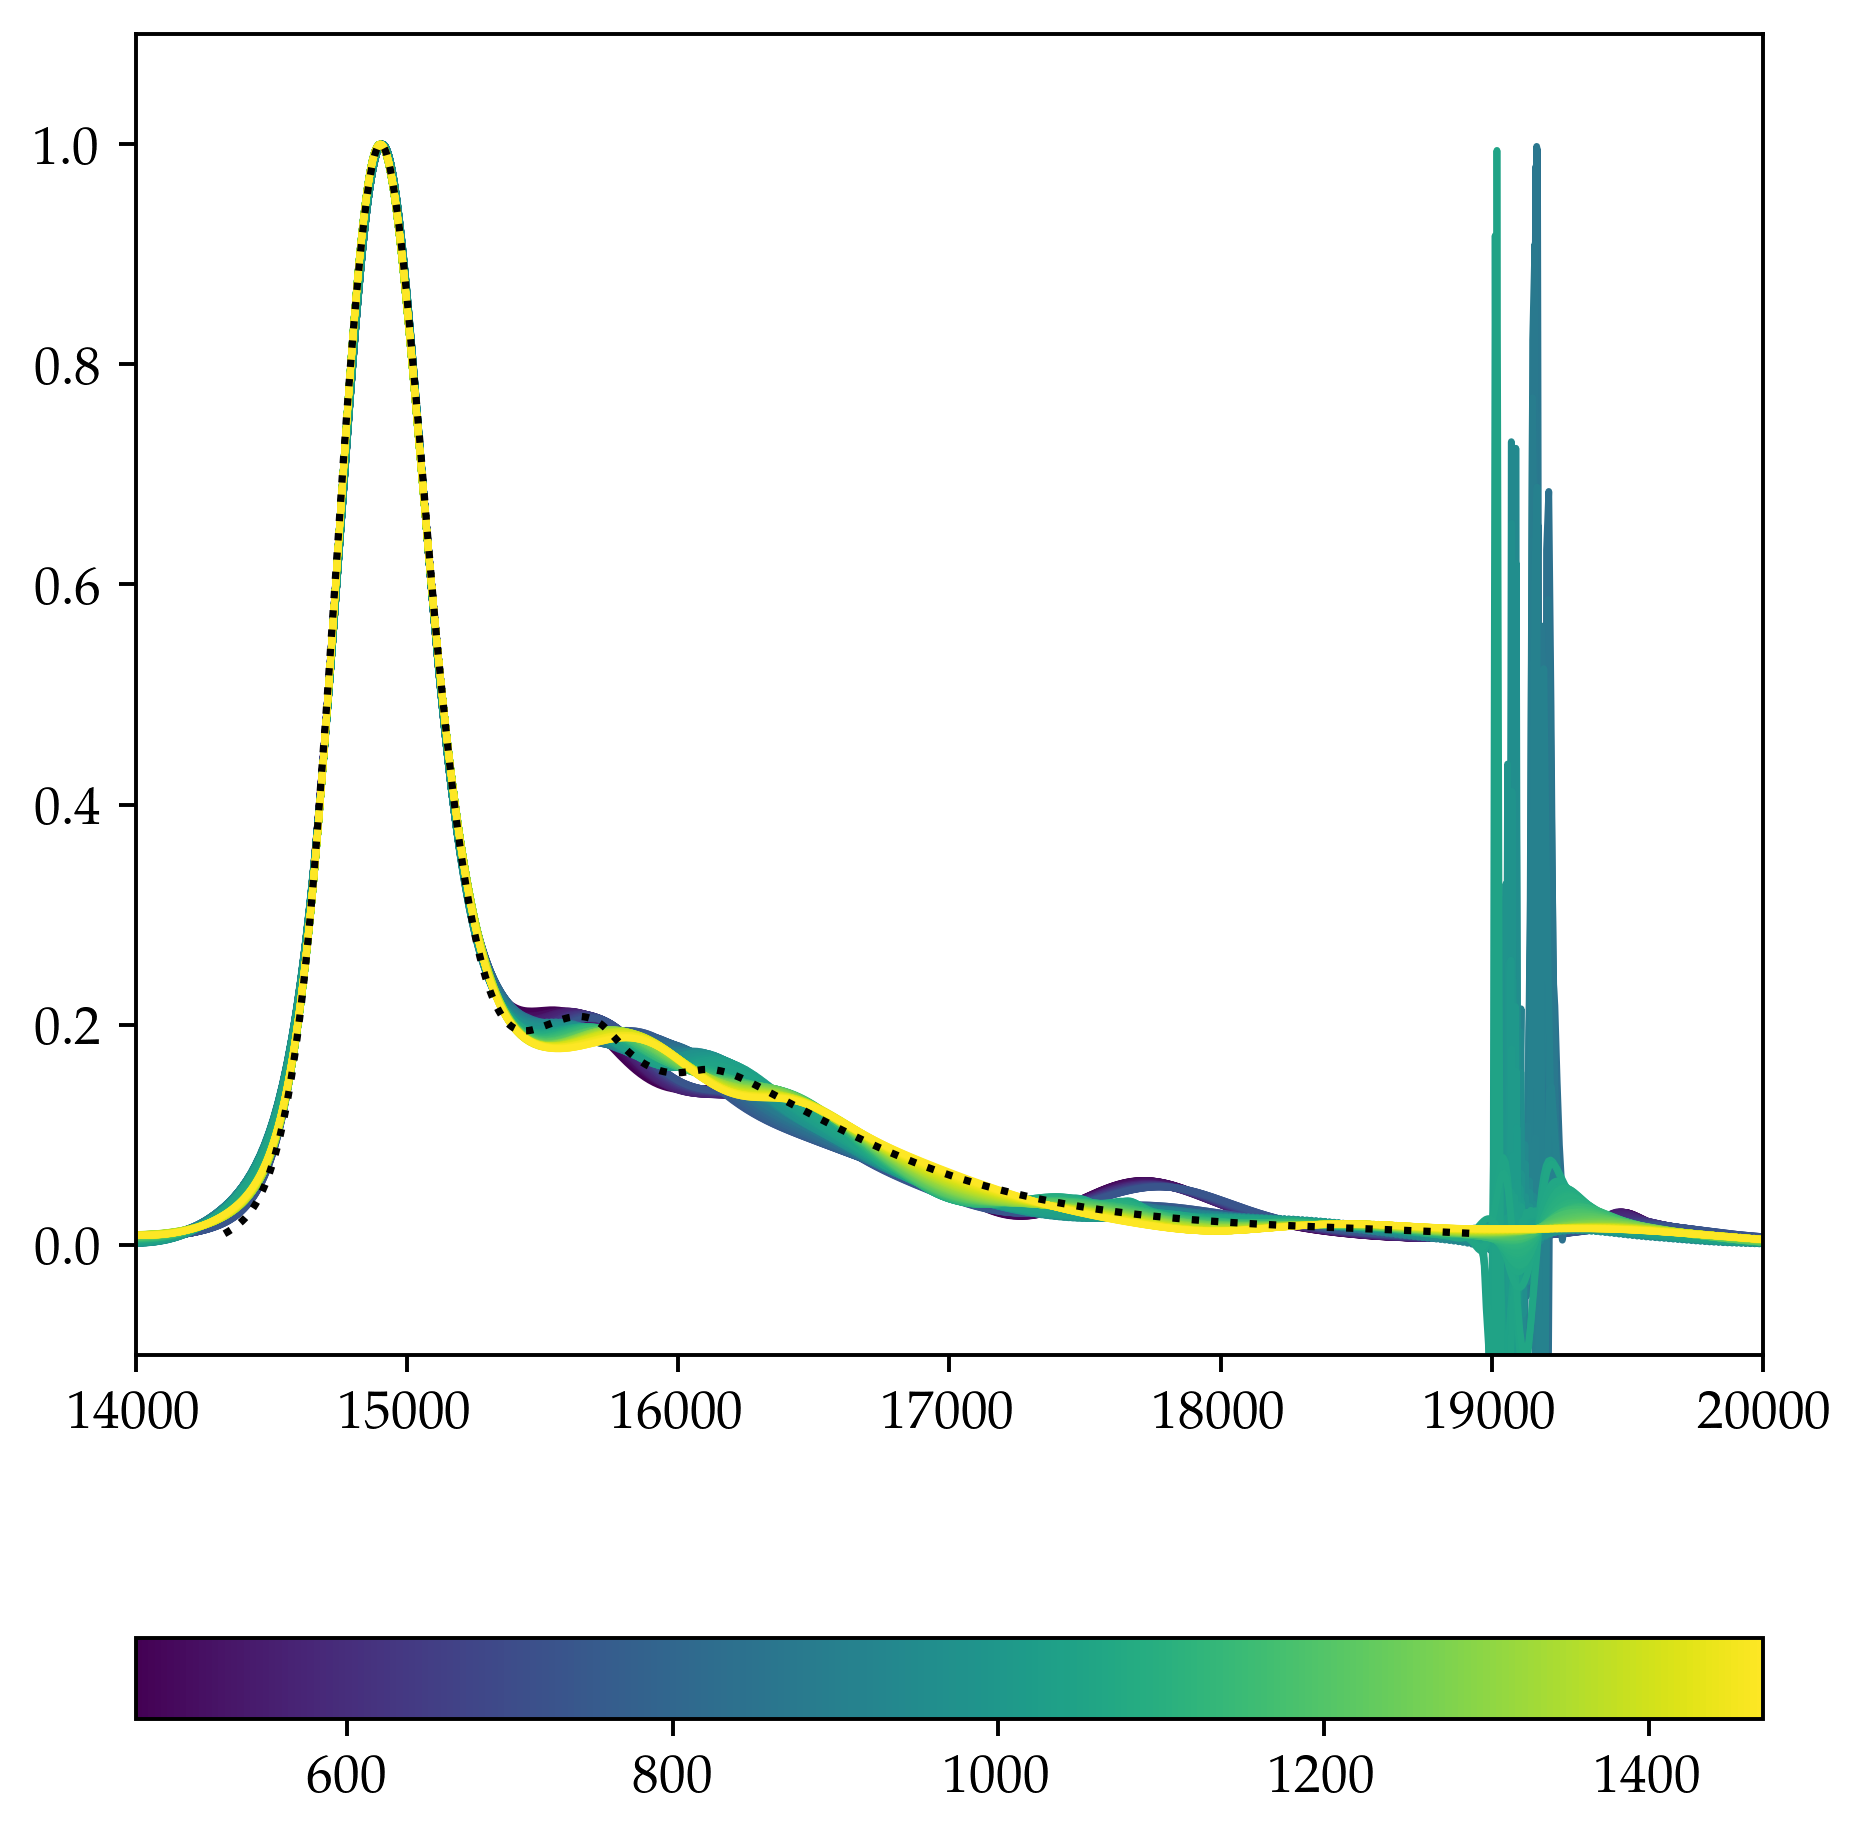

In [24]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(ref_id, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_47796\2928657806.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_47796\2928657806.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])
100%|███████████████████████████████████████████████████████████████████████████████████| 201/201 [00:05<00:00, 35.15it/s]


0.0389699531647


Text(0, 0.5, 'residuum')

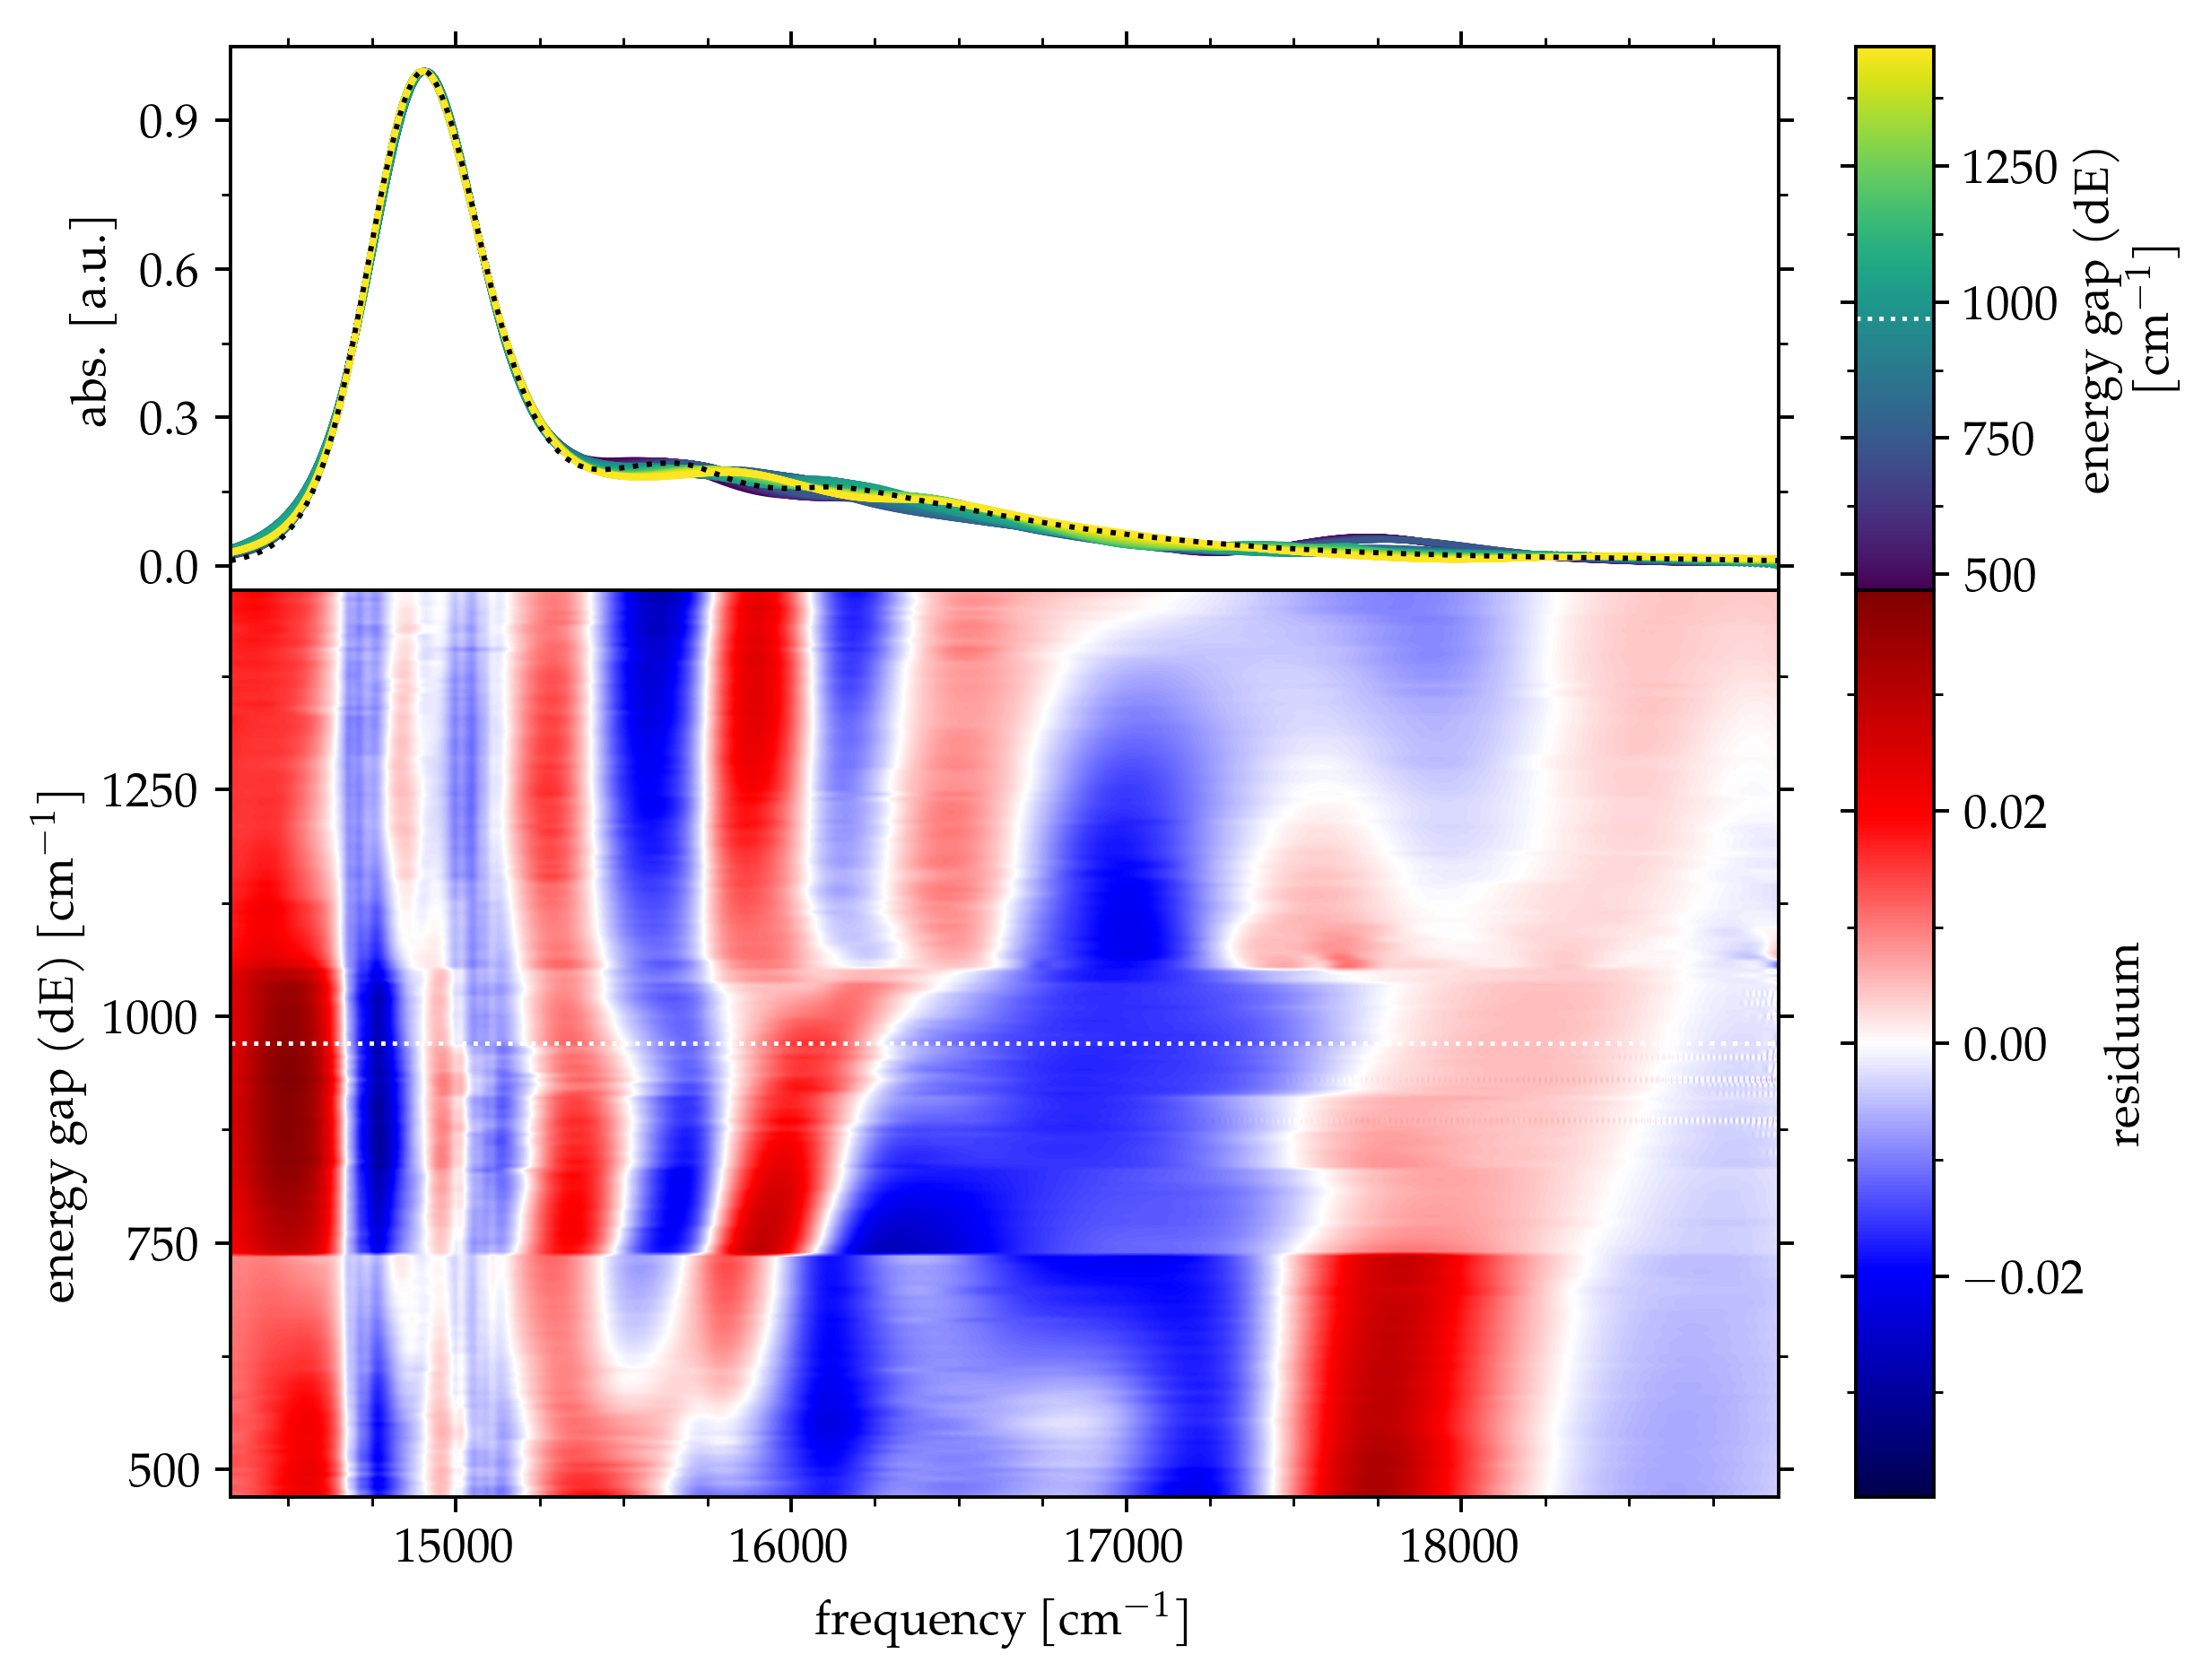

In [25]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(ref_id, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)[:,lim0:lim1]

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()
print(maximum)

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(ref_id, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax0.set_ylim(y[0,0], y[-1,0])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'energy gap (dE) [cm$^{-1}$]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering energy gap (dE) [cm$^{-1}$]')
ax4.set_ylabel(r'residuum')

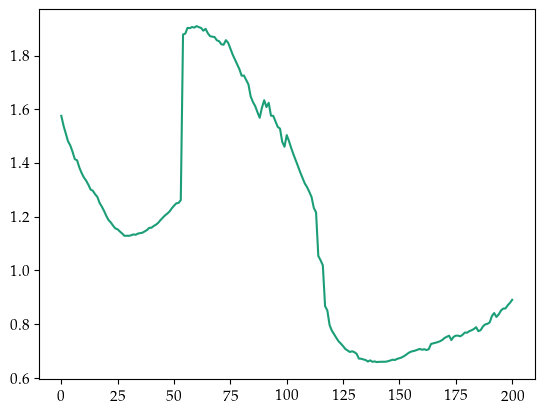

In [26]:
plt.plot((zax**2).sum(axis=1))

In [27]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_47796\2323635181.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'energy gap (dE) [cm$^{-1}$]')

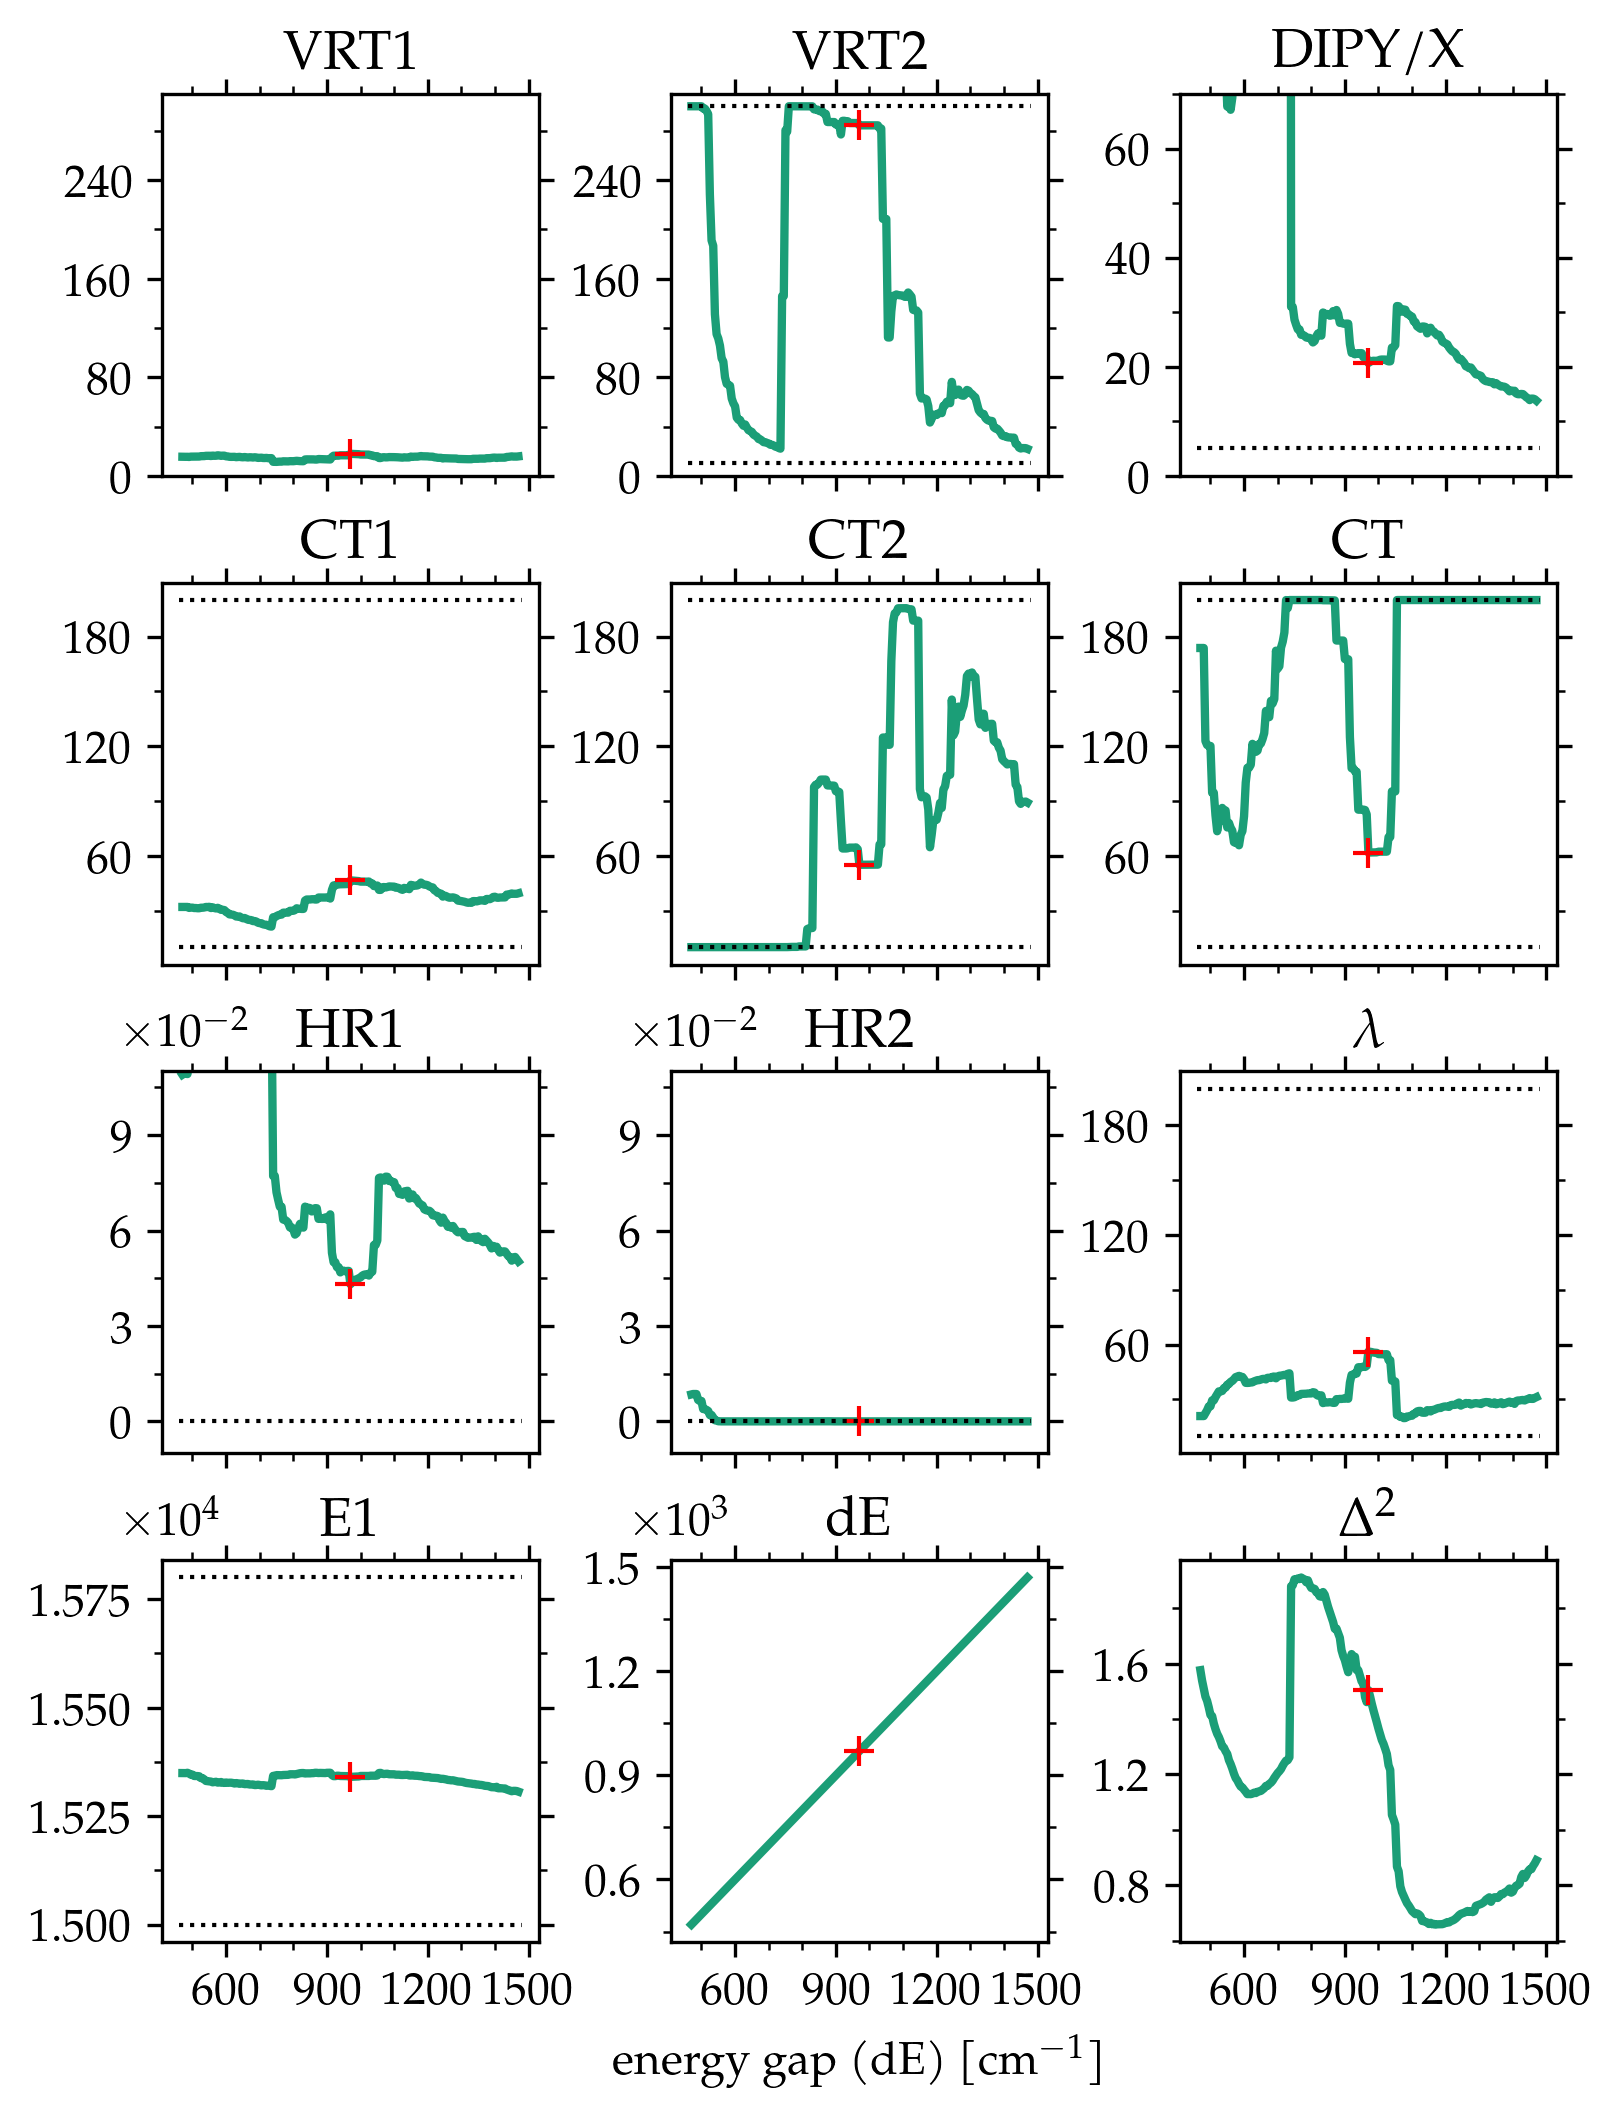

In [28]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[lim0:lim1]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == ivalue][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

# ## omega
# grid[3,1].plot(labels, om1, **pars)
# grid[3,1].plot(labels[ii], om1[ii], **mpars)
# grid[3,1].set_title('OM1')
# #draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

## dE
grid[3,1].plot(labels, de, **pars)
grid[3,1].plot(labels[ii], de[ii], **mpars)
grid[3,1].set_title('dE')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    

grid[0,0].set_ylim(0,310)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

#grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.11)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

#grid[0,0].set_xlim(10, 80)
grid[0,2].set_ylim(0,70)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(300))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(100))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('energy gap (dE) [cm$^{-1}$]')